In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [92]:
device = "cuda"

In [132]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 128

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
trainloader_acc = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/connection.py", line 416, in _send_bytes
    self._send(header + buf)
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/connection.py", line 373, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe


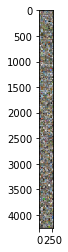

deer  truck plane ship  car   cat   truck plane cat   deer  cat   deer  car   dog   dog   frog  truck frog  bird  cat   truck car   deer  cat   plane horse ship  ship  ship  horse bird  truck frog  dog   car   bird  deer  car   dog   dog   ship  ship  frog  truck deer  deer  car   frog  truck plane horse plane bird  frog  cat   frog  deer  dog   frog  plane bird  ship  plane cat   ship  truck deer  horse deer  dog   truck car   cat   bird  deer  frog  car   frog  ship  horse dog   cat   deer  deer  frog  bird  plane horse dog   plane frog  horse plane truck frog  bird  cat   ship  dog   ship  car   plane frog  bird  plane frog  plane car   frog  bird  cat   cat   bird  bird  frog  cat   horse plane plane cat   ship  truck dog   car   horse deer  frog  bird  horse ship  deer  horse deer  ship  plane horse plane bird  car   cat   plane plane cat   dog   truck bird  ship  car   bird  cat   car   bird  dog   frog  plane truck ship  ship  frog  bird  bird  deer  horse deer  ship  frog  plan

In [123]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [180]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self, N_layers, M_per_layer, max_rank=None, activation=F.relu):
        super().__init__()
        if max_rank is None: max_rank = M_per_layer
        
        self.layers_a = []
        for i in range(N_layers):
            in_n = 32**2*3 if i==0 else M_per_layer
            out_n = 10 if i==N_layers-1 else M_per_layer
            self.layers_a.append(nn.Linear(in_n, out_n, bias=False))
            with torch.no_grad():
                Wahh = self.layers_a[i].weight
                Wahh = np.random.randn(Wahh.shape[0], Wahh.shape[1])
                u, s, vT = np.linalg.svd(Wahh, full_matrices=False)  # np.linalg.svd returns v transpose!
                Wahh = u @ vT  # make the eigenvalues large so they decay slowly
                Wahh = torch.tensor(Wahh, dtype=torch.float32)
                self.layers_a[i].weight[:, :] = Wahh[:, :]
        self.layers_a = nn.ModuleList(self.layers_a)
        self.activation = F.relu
        self.N_layers = N_layers

    def forward(self, x):
        x = torch.flatten(x, 1)
        for i in range(self.N_layers):
            x = self.layers_a[i](x)
            if i < self.N_layers-1:
                x = self.activation(x)
        return x
class Net_Rank(nn.Module):
    def __init__(self, N_layers, M_per_layer, max_rank=None, activation=F.relu):
        super().__init__()
        if max_rank is None: max_rank = M_per_layer
        
        self.layers_a = []
        self.layers_b = []
        for i in range(N_layers):
            in_n = 32**2*3 if i==0 else M_per_layer
            out_n = 10 if i==N_layers-1 else M_per_layer
            self.layers_a.append(nn.Linear(in_n, max_rank, bias=False))
            self.layers_b.append(nn.Linear(max_rank, out_n, bias=False))
            with torch.no_grad():
                Wahh = self.layers_a[i].weight
                Wahh = np.random.randn(Wahh.shape[0], Wahh.shape[1])
                u, s, vT = np.linalg.svd(Wahh, full_matrices=False)  # np.linalg.svd returns v transpose!
                Wahh = u @ vT  # make the eigenvalues large so they decay slowly
                Wahh = torch.tensor(Wahh, dtype=torch.float32)
                self.layers_a[i].weight[:, :] = Wahh[:, :]
            with torch.no_grad():
                Wahh = self.layers_b[i].weight
                Wahh = np.random.randn(Wahh.shape[0], Wahh.shape[1])
                u, s, vT = np.linalg.svd(Wahh, full_matrices=False)  # np.linalg.svd returns v transpose!
                Wahh = u @ vT  # make the eigenvalues large so they decay slowly
                Wahh = torch.tensor(Wahh, dtype=torch.float32)
                self.layers_b[i].weight[:, :] = Wahh[:, :]
        self.layers_a = nn.ModuleList(self.layers_a)
        self.layers_b = nn.ModuleList(self.layers_b)
        self.activation = F.relu
        self.N_layers = N_layers

    def forward(self, x):
        x = torch.flatten(x, 1)
        for i in range(self.N_layers):
            x = self.layers_a[i](x)
            x = self.layers_b[i](x)
            if i < self.N_layers-1:
                x = self.activation(x)
        return x
    
def accuracy(net, test=False):
    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in testloader if test else trainloader_acc:
            images, labels = data
            # calculate outputs by running images through the network
            outputs = net(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

In [181]:
net = Net_Rank(N_layers=12, M_per_layer=1024)

In [184]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.005)#, momentum=0.9)
#optimizer = optim.Adam(net.parameters(), lr=0.05)
#print(accuracy(net))
for epoch in range(20):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 20 == 19:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 20:.10f}')
            #print(accuracy(net))
            running_loss = 0.0

print('Finished Training')

[1,    20] loss: 0.1686342813
[1,    40] loss: 0.1426032841
[1,    60] loss: 0.1357714821
[1,    80] loss: 0.1199393289
[1,   100] loss: 0.1230657700
[1,   120] loss: 0.1152646335
[1,   140] loss: 0.1002065448
[1,   160] loss: 0.1060446152
[1,   180] loss: 0.0933579728
[1,   200] loss: 0.0761421131
[1,   220] loss: 0.0796360467
[1,   240] loss: 0.0734393936
[1,   260] loss: 0.0800296178
[1,   280] loss: 0.0730491379
[1,   300] loss: 0.0764400279
[1,   320] loss: 0.0667668866
[1,   340] loss: 0.0728329909
[1,   360] loss: 0.0736293636
[1,   380] loss: 0.0757575297
[2,    20] loss: 0.0293611383
[2,    40] loss: 0.0403765202
[2,    60] loss: 0.0373729638
[2,    80] loss: 0.0348358700
[2,   100] loss: 0.0330511586
[2,   120] loss: 0.0416225756
[2,   140] loss: 0.0303280825
[2,   160] loss: 0.0325738832
[2,   180] loss: 0.0310957293
[2,   200] loss: 0.0372472205
[2,   220] loss: 0.0304134656
[2,   240] loss: 0.0352580560
[2,   260] loss: 0.0300687201
[2,   280] loss: 0.0277756691
[2,   300]

[15,   100] loss: 0.0007844236
[15,   120] loss: 0.0003553737
[15,   140] loss: 0.0002891141
[15,   160] loss: 0.0003815089
[15,   180] loss: 0.0003562057
[15,   200] loss: 0.0003775487
[15,   220] loss: 0.0003733367
[15,   240] loss: 0.0003335611
[15,   260] loss: 0.0002679035
[15,   280] loss: 0.0002815883
[15,   300] loss: 0.0002909759
[15,   320] loss: 0.0002928172
[15,   340] loss: 0.0002329644
[15,   360] loss: 0.0002534684
[15,   380] loss: 0.0002918277
[16,    20] loss: 0.0002881236
[16,    40] loss: 0.0002006867
[16,    60] loss: 0.0003950287
[16,    80] loss: 0.0002849098
[16,   100] loss: 0.0003429443
[16,   120] loss: 0.0002424973
[16,   140] loss: 0.0003532006
[16,   160] loss: 0.0002838389
[16,   180] loss: 0.0002754922
[16,   200] loss: 0.0002543273
[16,   220] loss: 0.0002849923
[16,   240] loss: 0.0001864255
[16,   260] loss: 0.0003379038
[16,   280] loss: 0.0003139725
[16,   300] loss: 0.0003473654
[16,   320] loss: 0.0002684126
[16,   340] loss: 0.0002305704
[16,   3

In [ ]:
print(accuracy(net)), print(accuracy(net, test=True))